<a href="https://colab.research.google.com/github/SmrithiCh/PRA3024-/blob/main/PRA3024_Cosmology_W3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='deepskyblue'>Cosmology MCMC notebook </font>








italicized text## <font color='deepskyblue'>Preliminaries</font>

In [24]:
# Install required packages (if not available on server)
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

import astropy
from astropy import cosmology
from astropy import units as u

import pandas as pd

from typing import Hashable


<font color='tomato'>
(NB: The equations you'll directly need to build your code are those $\boxed{\text{with a box around}}$)
</font>

## <font color='deepskyblue'>The $\Lambda$CDM Model</font>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$. While photons (light rays) travel in the expanding universe they get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$


In the $\Lambda$CDM model (and at late enough times), this additionally simplifies to

$$
\begin{gathered}
\boxed{
H^2 = H_0^2\left[\Omega_\Lambda + \Omega_m (1+z)^3 + \Omega_k (1+z)^2\right]
}
\\
\boxed{
\Omega_m + \Omega_\Lambda + \Omega_k = 1
}
\end{gathered}
\tag{1}
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. NB: only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
\boxed{
  H_0 \equiv 100\,h\,\frac{\rm km}{\rm s\,Mpc}
}
\tag{2}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m.

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

## <font color='deepskyblue'>Supernovae Ia</font>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

We can express the luminosity distance in terms of the Hubble rate:

$$
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \,\sinh\left(\sqrt{\Omega_k}\,D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \,\sin\left(\sqrt{-\Omega_k}\,D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
\tag{3}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.
In practice, however, the actual observable for [Supernovae Type Ia](https://en.wikipedia.org/wiki/Type_Ia_supernova) (or SNIa) is the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$, defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag{4}
$$

We can create the function `dL(z, h, Omega_m, Omega_Lambda)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator, for example implementing the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) or your favourite alternative, or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in units of 100 km/s/Mpc (which we called $h$).

In [105]:
# Defining the LambdaCDM model using equations [1] and [2]

def Hubble(z, OmegaL, OmegaM, H0):
  OmegaK = 1 - OmegaL - OmegaM
  H = H0 * np.sqrt(OmegaL + OmegaM*(1+z)**3 + OmegaK*(1+z)**2) #equation [1]

  return H

c = astropy.constants.c.value / 10**3 #speed of light in km/s

# Comoving Distance: Integrate H0/H from x = 0 to x = z
def D(z, OmegaL, OmegaM, H0): # defines the comoving distance
    return H0 * integrate.quad(lambda x: (1/Hubble(x, OmegaL, OmegaM, H0)),0,z)[0]

# Luminosity Distance for open, flat and closed universes: equation [3]
def dL(z, OmegaL, OmegaM, H0):
    OmegaK= 1-OmegaL-OmegaM
    Dz = D(z, OmegaL, OmegaM, H0)

    if OmegaK > 0:
        dl = (1/np.sqrt(OmegaK))*np.sinh(np.sqrt(OmegaK)*Dz)
    if OmegaK == 0:
        dl = Dz
    if OmegaK < 0:
        dl = (1/np.sqrt(-OmegaK))*np.sin(np.sqrt(-OmegaK)*Dz)
    dL_ = c * (1+z) * dl / H0 * 10**6

    return dL_


# Distance Modulus: equation [4]
def mu(z, OmegaL, OmegaM, H0): # distance modulus: equation [4]
  mu_ = 5 * (np.log10(dL(z, OmegaL, OmegaM, H0))-np.log10(10))

  return mu_

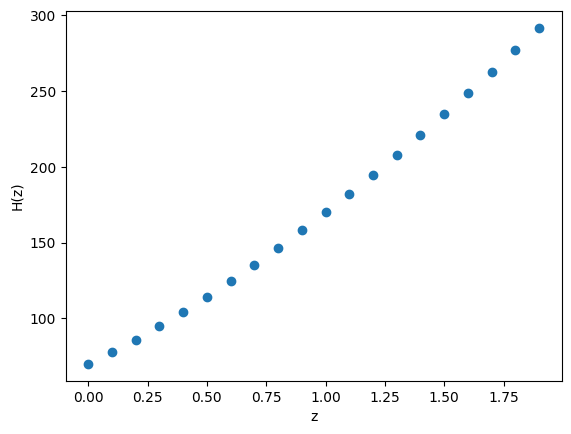

<ipython-input-105-93ab8139d2db>:33: RuntimeWarning: divide by zero encountered in log10
  mu_ = 5 * (np.log10(dL(z, OmegaL, OmegaM, H0))-np.log10(10))


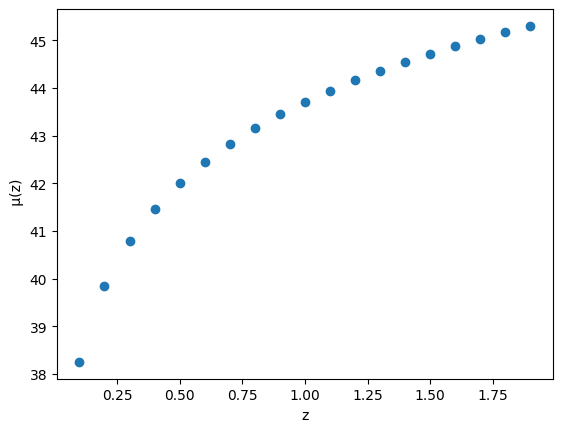

In [106]:
#Test functions
%matplotlib inline
OmegaL = 0.3
OmegaM = 0.7
h=0.7

zs=np.arange(0, 2, 0.1)
Hs = []
for z in zs :
    Hs += [Hubble(z, OmegaL, OmegaM, H0)]

plt.scatter (zs, Hs) # Hubble against redshift
plt.xlabel ('z')
plt.ylabel ('H(z)')
plt.show ()

%matplotlib inline
zs=np.arange(0, 2, 0.1)
mus = []
for z in zs :
    mus += [mu(z, OmegaL, OmegaM, H0)]

plt.scatter (zs, mus) # Distance modulus vs redshift
plt.xlabel ('z')
plt.ylabel (' μ(z)')
plt.show ()

## <font color='deepskyblue'>The Union2.1 Compilation</font>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$
Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [107]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
display(data[0])

array([      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01])

In [108]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift

# ...or transpose the array and then slice by row: arr_transposed[n]
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

In [109]:
# Let's look at the data, just for fun.
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once with something like:
#     array_2 = some_function_of(array_1)

# luminosity distance in Mpc
lum_dist_mpc = 1.E-5 * 10.**(distance_modulus / 5.)

# error on luminosity distance
err_lum_dist_mpc = 5. * (10.**((distance_modulus + error_distance_modulus)/5.-6.) - 10.**((distance_modulus - error_distance_modulus)/5.-6.))

# store the data in a pandas dataframe for easier manipulation
dataframe = pd.DataFrame({"redshift":zs,
                   "distance_modulus":distance_modulus,
                   "distance_modulus_error":error_distance_modulus,
                   "luminosity_distance_Mpc":lum_dist_mpc ,
                   "error_luminosity_distance_Mpc":err_lum_dist_mpc})
dataframe.describe()

,redshift,distance_modulus,distance_modulus_error,luminosity_distance_Mpc,error_luminosity_distance_Mpc
count,580.000000,580.000000,580.000000,580.000000,580.000000
mean,0.361631,40.028495,0.222955,2209.306847,289.336492
std,0.327353,3.195595,0.126012,2317.338603,441.344011
min,0.015000,33.824609,0.084144,58.199838,4.207930
25%,0.054550,36.920249,0.151396,242.219796,16.661538
50%,0.294028,40.884198,0.189029,1502.674447,120.529500
75%,0.551700,42.517637,0.241556,3188.076719,398.462205
max,1.414000,45.410744,1.006812,12082.277932,3550.896956


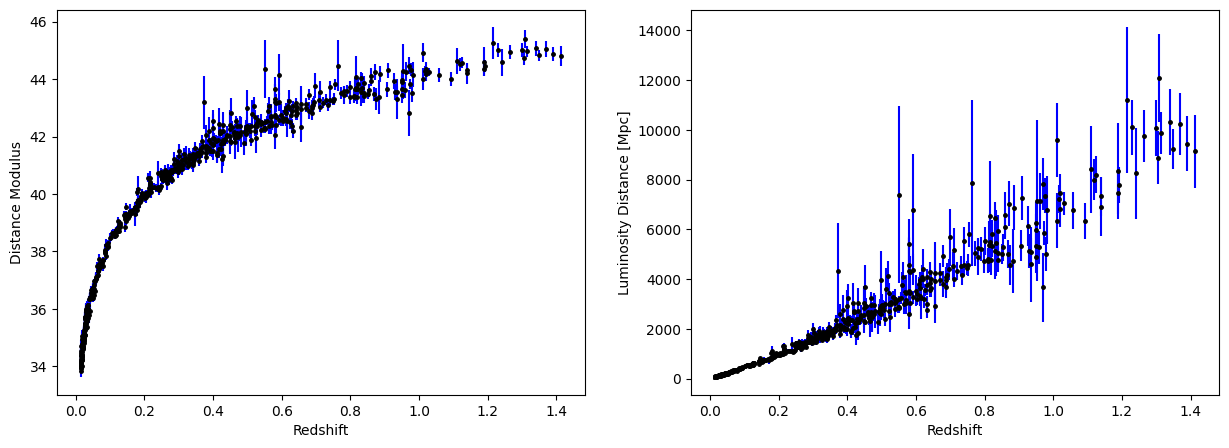

In [110]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot: Distance Modulus vs Redshift
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, distance_modulus,\
             yerr=error_distance_modulus,\
             fmt='.',\
             color='black',\
             ecolor='blue',\
             markersize=5)



# Plot: Luminosity Distance vs. Redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, lum_dist_mpc,\
             yerr = err_lum_dist_mpc,\
             fmt='.',\
             markersize='5',\
             color='k',\
             ecolor = 'b')

plt.show()

## <font color='deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</font>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*).
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$.
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <font color='deepskyblue'>Prior</font>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.).

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <font color='deepskyblue'>Likelihood</font>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag{5}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood.

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not unheard of, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than $10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <font color='deepskyblue'>Evidence</font>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <font color='deepskyblue'>Posterior</font>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <font color='deepskyblue'>Markov-Chain Monte Carlo</font>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied.
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (5), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)


* <font color="deepskyblue"> Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values) </font>
* <font color="deepskyblue"> Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$</font>
* <font color="deepskyblue"> Draw a random number $r \in [0,1]$</font>
* <font color="deepskyblue"> Accept the step if
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$</font>
    * <font color="deepskyblue"> If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$</font>
    * <font color="deepskyblue">If you want, you can keep a record of the best fit (lowest $\chi^2$), but this is not the specific purpose of MCMC! We are exploring the parameter space and sampling a _posterior distribution_, not just finding the best fit</font>
* <font color="deepskyblue"> Record the step - including **re-recording** if the step was not accepted! </font>
* <font color="deepskyblue"> Repeat</font>

In [133]:
# We can vectorize the mu function to massively speed up the analysis
function = np.vectorize(mu)
# The way to speed up this function even further is to create a new function which already does the operations on
# the redshifts and just takes the parameters as variables instead of repeating the operations on the redshifts
mu_vec = lambda h, OmegaM, OmegaL: function(dataframe['redshift'], h,OmegaM,OmegaL)


# A few thousand *ACCEPTED* steps is a decent ballpark for the minimum length of your MCMC chain
# NB: start with a few hundreds, see if everything works as expected, and then commit to a longer run (>= 5000 steps)
N_steps = 250


# Displacement of parameters at each step (uniform)

def new_parameters(h, omega_m, omega_l):
    new_h = np.random.normal(h, 0.05)
    new_omega_m = np.random.normal(omega_m, 0.01)
    new_omega_l = np.random.normal(omega_l, 0.01)
    return np.array([new_h, new_omega_m, new_omega_l])

# Defining the chi2 function
def chi2(h, omega_m, omega_l):
    return np.sum(np.square(np.subtract(mu_vec(h,omega_m, omega_l),dataframe['distance_modulus'])))

# Criteria on which to accept or reject the new parameters
def accept_move(chi2current, chi2prop):
    #generating a random value between 0 and 1
    r = np.random.uniform(0,1)

    if chi2prop < chi2current: #accept if new chi2 is smaller (better) than the existing
        return True
    elif r <= min(1,np.exp(-(chi2prop - chi2current)/2)) : # accept if chi2 is larger but the step follows the inequlity in blue (above)
        return True
    else:
        return False # discard new chi2 value if the blue inequality is not met

# Parameters
chain = []
accepted = []
rejected = []
# Parameter Starting Values
n = 0
#makes a number of steps based on the length of the dataframe: optimizes MCMC so as not to use too many steps as recommended by Lorenzo
N_steps = len(dataframe['redshift'])
# add a burn in period of 15 steps as they will not be very good
burn_in = 15
theta0 = np.array([0.5, 0.5, 0.5]) # starting from a very bad value to show the MCMC is effective

filename = "MC_Chain_SNIa.dat"
# set the value of the chi2 for the current parameters
chi2current=chi2(*theta0)
# Open the file and give a Heading
# Accepted values will record accepted values during the MCMC
# File is automatically closed at the end
with open(filename, 'w') as f:
    f.write("h\tOmega_M\tOmega_L\tOmegaK\tchi2\t")
    while n < N_steps:
        print(f"step {n}/{N_steps}")
        # Propose a new set of parameters by generating a random Gaussian distribution around the current parameters
        thetaprop = new_parameters(*theta0)
        # Initialize the chi2 for the proposed parameters
        chi2prop = chi2(*thetaprop)
        # Accept or reject the proposed parameters using the function accept_move
        if accept_move(chi2current,chi2prop):
            # if the move is accepted, we set the current parameters to the proposed parameters
            theta0 = thetaprop
            # and the current chi2 to the chi2 of the proposed parameters
            chi2current = chi2prop
            # and lastly we record the new parameters and chi2 value in the .dat file
            if n>= burn_in:
                f.write(f"\n{theta0[0]}\t{theta0[1]}\t{theta0[2]}\t{1-theta0[1]-theta0[2]}\t{chi2current}\t")
                chain.append(theta0)
            accepted.append(chi2prop)
        else:
            rejected.append(chi2prop)
        # we increase the counter by 1 nonetheless
        n += 1

step 0/580
step 1/580
step 2/580
step 3/580
step 4/580
step 5/580
step 6/580
step 7/580
step 8/580
step 9/580
step 10/580
step 11/580
step 12/580
step 13/580
step 14/580
step 15/580
step 16/580
step 17/580
step 18/580
step 19/580
step 20/580
step 21/580
step 22/580
step 23/580
step 24/580
step 25/580
step 26/580
step 27/580
step 28/580
step 29/580
step 30/580
step 31/580
step 32/580
step 33/580
step 34/580
step 35/580
step 36/580
step 37/580
step 38/580
step 39/580
step 40/580
step 41/580
step 42/580
step 43/580
step 44/580
step 45/580
step 46/580
step 47/580
step 48/580
step 49/580
step 50/580
step 51/580
step 52/580
step 53/580
step 54/580
step 55/580
step 56/580
step 57/580
step 58/580
step 59/580
step 60/580
step 61/580
step 62/580
step 63/580
step 64/580
step 65/580
step 66/580
step 67/580
step 68/580
step 69/580
step 70/580
step 71/580
step 72/580
step 73/580
step 74/580
step 75/580
step 76/580
step 77/580
step 78/580
step 79/580
step 80/580
step 81/580
step 82/580
step 83/580
st

In [134]:
# load the data into a pandas dataframe
data = pd.read_csv("MC_Chain_SNIa.dat", sep="\t")
data

,h,Omega_M,Omega_L,OmegaK,chi2,Unnamed: 5
0,0.625119,0.489915,0.593324,-0.083239,61086.415867,NaN
1,0.554126,0.490618,0.598853,-0.089471,60678.420938,NaN
2,0.637394,0.496579,0.619110,-0.115689,60001.816265,NaN
3,0.597152,0.497860,0.636683,-0.134543,59189.690388,NaN
4,0.614138,0.518100,0.639231,-0.157331,59070.519218,NaN
...,...,...,...,...,...,...
291,-3.456882,0.680628,2.493754,-2.174382,25432.718300,NaN
292,-3.424339,0.665818,2.519624,-2.185442,25292.132217,NaN
293,-3.408377,0.662404,2.526865,-2.189269,25257.053490,NaN
294,-3.514691,0.662503,2.540239,-2.202742,25102.450824,NaN


# **We are given a non-zero Omega_L value, but it is far from accurate**

## (this would be an undesireable value even when the omegal value was unknown as the value for h is negative)

## <font color='deepskyblue'>Plotting: GetDist</font>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

<font color='deepskyblue'>
Look at your results. Do you obtain $\Omega_\Lambda \neq 0$? To a high degree of significance?

If yes, then my dear friend, you have **DISCOVERED THE ACCELERATED EXPANSION OF THE UNIVERSE AND WON THE NOBEL PRIZE IN PHYSICS 2011!**
</font>

Removed no burn in
-2.94  <  h  <  -0.45  at  68 % CL
0.6  <  OmegaM  <  0.74  at  68 % CL
0.89  <  OmegaL  <  2.21  at  68 % CL
-1.96  <  Omegak  <  -0.53  at  68 % CL





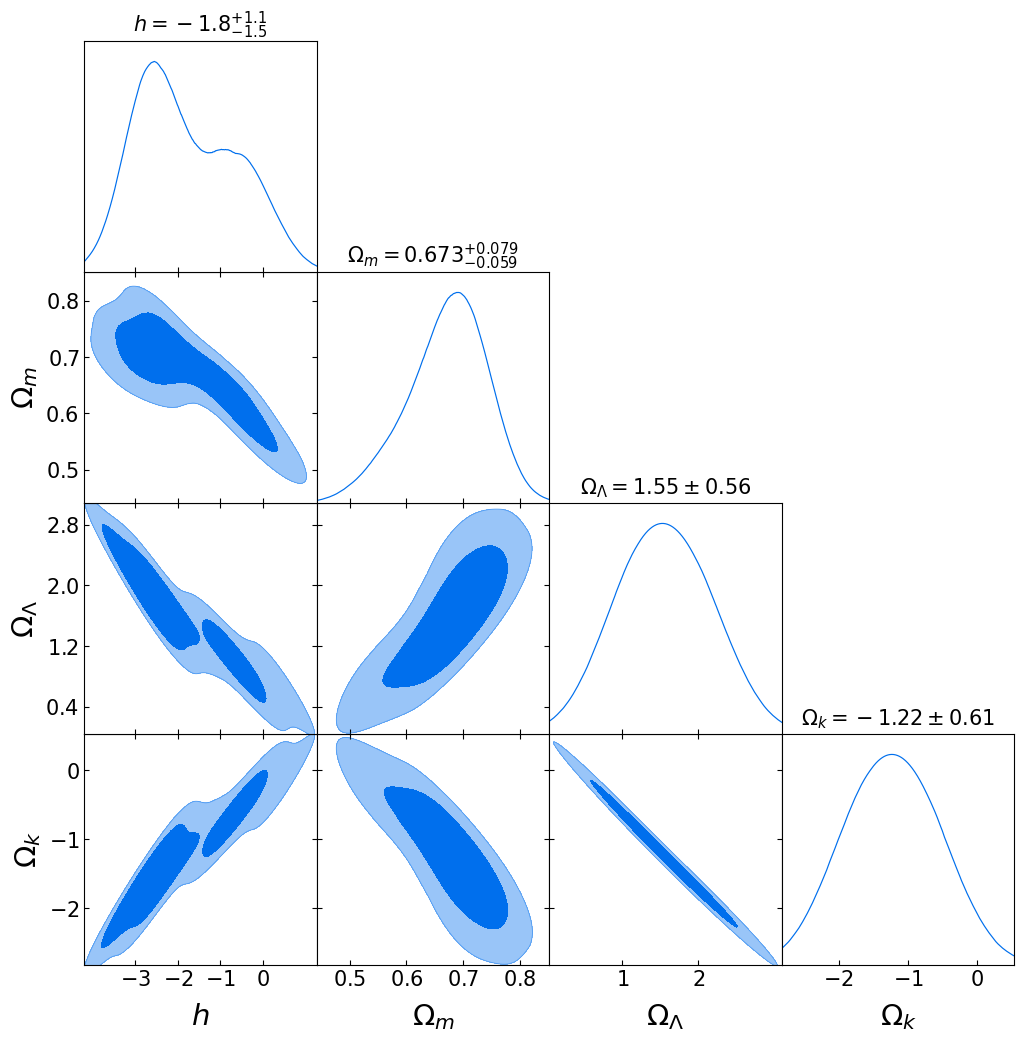

In [135]:
# Defining variables from MCMC chain
h, OmegaM, OmegaL, Omegak = data["h"], data["Omega_M"], data["Omega_L"], data["OmegaK"]

# Define variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names) # The number of variables we're plotting


my_samples = np.array([h, OmegaM, OmegaL, Omegak]) # This creates a higher-dimensional array with all our data,
my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim)))) # and this reshapes it in a convenient form...
samples1 = MCSamples(samples = my_samples, labels = my_labels, names = my_names) # ... to create an "MCSamples" data type, which GetDist can use

# The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want
conf_level = 0.6827

# This prints a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(samples1.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples1.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled = True, title_limit=1)

# **Looks horrendously bad, MCMC needs to be optimised**

## <font color='deepskyblue'>Further Improvements</font>

### **Gelman-Rubin Convergence Test**

In [136]:
#Recreate the code to do a single run
class mcmc:
    def __init__(self):
        self.accepted = []
        self.c = []
        # create the list of rejected chi2 values
        self.rejected = []
        # create the number of steps
        self.N_steps = len(dataframe['redshift'])
        # create the parameters
        self.burn_in = 15

    def run_chain(self,i):
        n = 0
        # create the parameters, using a uniform distribution and some prior knowledge about the parameters
        theta0 = np.random.uniform([0.5, 0.3, 0.5], [1, 0.4, 0.9])
        # create the chi2 for the current parameters
        chi2current=chi2(*theta0)
        filename = f"MC_Chain_SNIa_{i}.dat"
        # Open the file and write the header, while the loop is running we will write the accepted values in the file
        with open(filename, 'w') as f:
            f.write("h\tOmega_M\tOmega_L\tOmegaK\tchi2\t")
            while n < self.N_steps:
                # Propose a new set of parameters by generating a random normal distribution around the current parameters
                thetaprop = new_parameters(*theta0)
                # Initialize the chi2 for the proposed parameters
                chi2prop = chi2(*thetaprop)
                # Accept or reject the proposed parameters using the function accept_move
                if accept_move(chi2current,chi2prop):
                    # if the move is accepted, we set the current parameters to the proposed parameters
                    theta0 = thetaprop
                    # and the current chi2 to the chi2 of the proposed parameters
                    chi2current = chi2prop
                    # and lastly we record the new parameters and chi2 value in the .dat file
                    if n >= self.burn_in:
                        f.write(f"\n{thetaprop[0]}\t{thetaprop[1]}\t{thetaprop[2]}\t{1-thetaprop[1]-thetaprop[2]}\t{chi2prop}\t")
                        self.accepted.append(chi2prop)
                    self.c.append(theta0)
                else:
                    self.rejected.append(chi2prop)
                # we increase the counter by 1 nonetheless
                n += 1

In [137]:
class mcmc_convergence_test(mcmc):
    # We inherit the mcmc class
    def __init__(self, Nchains):
        # We call the __init__ function of the mcmc class
        super().__init__()
        self.Nchains = Nchains
        self.chains = [mcmc() for i in range(self.Nchains)]
        self.data = {}
    def run_convergence_test(self):
        # create the chains
        for chain in self.chains:
            print("Running chain", self.chains.index(chain)+1, "of", self.Nchains)
            # Run the chains
            chain.run_chain(self.chains.index(chain)+1)

        # Calculate the within-chain variances
        # We use ddof=1 to calculate the sample variance instead of the population variance
        W = np.mean([np.var(chain.accepted, ddof=1) for chain in self.chains])
        print(self.Nchains)
        # Calculate the between-chain variances
        # We use axis=0 to calculate the mean of each column
        theta_bar = [np.mean(chain.accepted, axis=0) for chain in self.chains]
        # B is the between-chain variance, which is the sum of the squared differences between the mean of each parameter and the mean of all parameters
        B = self.N_steps / (self.Nchains-1) * np.sum(np.square(theta_bar - np.mean(theta_bar, axis=0)), axis=0)
        # Calculate the estimated variances
        # N is the total number of steps taken
        N = sum([len(chain.accepted) for chain in self.chains])
        # V_hat is the weighted average of W and B
        V_hat = (N-1)/N * W + B/N

        # Calculate the potential scale reduction factor, which is the square root of V_hat divided by W
        R_hat = np.sqrt(V_hat/W)

        # store the results
        self.data["Number of chains"]=self.Nchains
        self.data["Within-chain variance (W)"]=W
        self.data["Between-chain variance (B)"]=B
        self.data["Estimated variance (V_hat)"]=V_hat
        self.data["Potential scale reduction factor (R_hat)"]=R_hat
        # Check for convergence
        if R_hat < 1.1:
            print("The chains have converged.")
        else:
            print("The chains have not yet converged.")
    def plot(self):
        for chains in self.chains:
            plt.plot(chains.accepted, label=f"Chain {self.chains.index(chains)+1}")

        plt.legend()


In [138]:
# create an instance of the convergence test class with 20 chains
convergence_test = mcmc_convergence_test(25)
# run the convergence test
convergence_test.run_convergence_test()

Running chain 1 of 25
Running chain 2 of 25
Running chain 3 of 25
Running chain 4 of 25
Running chain 5 of 25
Running chain 6 of 25
Running chain 7 of 25
Running chain 8 of 25
Running chain 9 of 25
Running chain 10 of 25
Running chain 11 of 25
Running chain 12 of 25
Running chain 13 of 25
Running chain 14 of 25
Running chain 15 of 25
Running chain 16 of 25
Running chain 17 of 25
Running chain 18 of 25
Running chain 19 of 25
Running chain 20 of 25
Running chain 21 of 25
Running chain 22 of 25
Running chain 23 of 25
Running chain 24 of 25
Running chain 25 of 25
25
The chains have converged.


In [139]:
# determine the mean of each parameter for each chain after convergence and store them in a dictionary
params = {"h":[], "Omega_M":[], "Omega_L":[], "OmegaK":[]}
for i in range(20):
    # loop over the 20 chains
    with open(f"MC_Chain_SNIa_{i+1}.dat", 'r') as f:
        # read the data from the .dat file
        data = pd.read_csv(f, sep="\t")
        # calculate the mean of each parameter and append it to the corresponding list in the dictionary
        params["h"] += [np.mean(data['h'])]
        params["Omega_M"]+= [np.mean(data['Omega_M'])]
        params["Omega_L"]+= [np.mean(data['Omega_L'])]
        params["OmegaK"]+= [np.mean(data['OmegaK'])]

Removed no burn in
-1.98  <  h  <  -1.36  at  68 % CL
0.31  <  OmegaM  <  0.49  at  68 % CL
1.6  <  OmegaL  <  1.93  at  68 % CL
-1.39  <  Omegak  <  -0.96  at  68 % CL





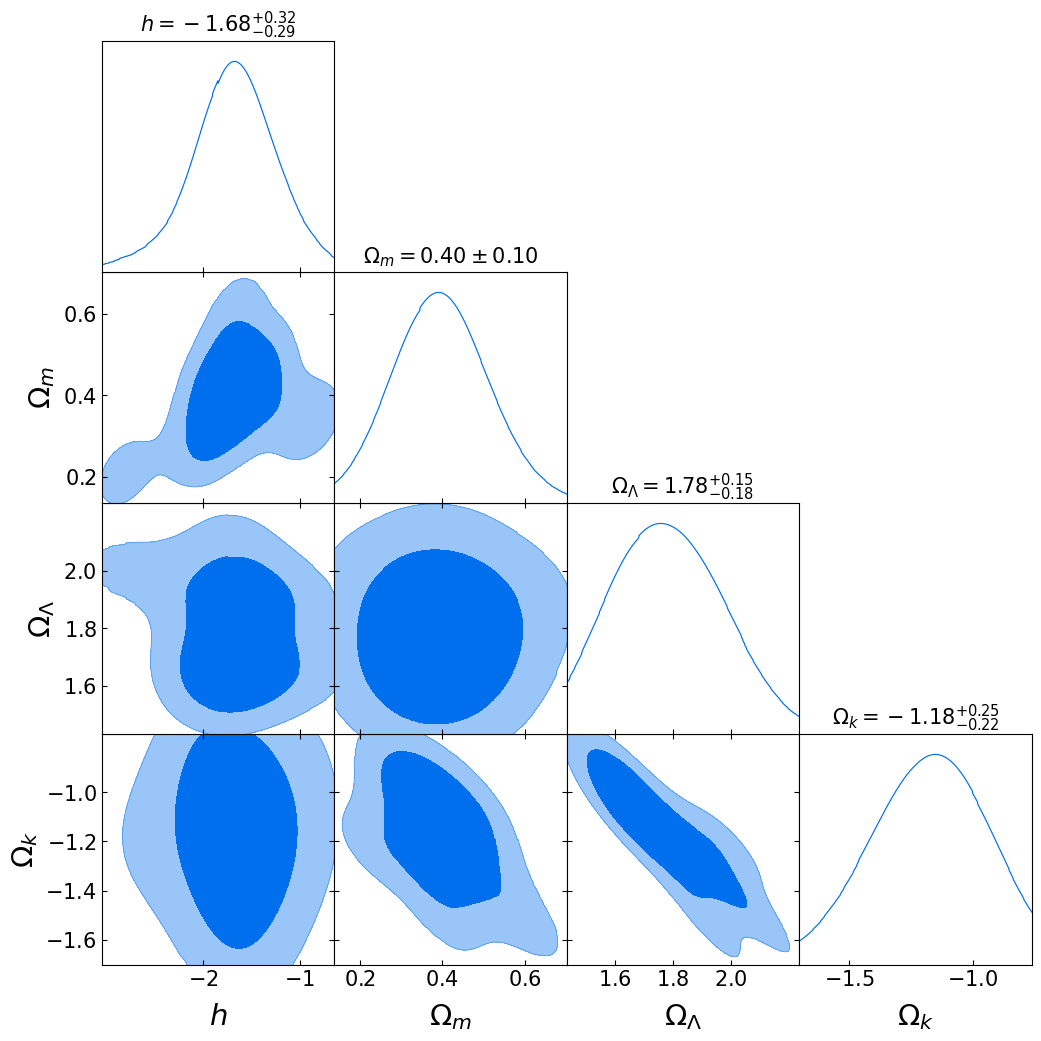

In [140]:
# plot the chains
h, OmegaM, OmegaL, Omegak = params["h"], params["Omega_M"], params["Omega_L"], params["OmegaK"]

# Here let's just define variable names, labels, and so on
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = 4 # The number of variables we're plotting

my_samples = np.array([h, OmegaM, OmegaL, Omegak]) # This creates a higher-dimensional array with all our data,
my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim)))) # and this reshapes it in a convenient form...
samples1 = MCSamples(samples = my_samples, labels = my_labels, names = my_names) # ... to create an "MCSamples" data type, which GetDist can use

conf_level = 0.6827 # The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want

# Let's print a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(samples1.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples1.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled = True, title_limit=1)